データを「走れメロス」に変える

In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm

np.random.seed(1234)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 500)
plt.rcParams["font.family"] = "IPAPGothic"
sns.set_style("white")

%matplotlib inline

In [2]:
import networkx as nx
import MeCab
from collections import defaultdict, Counter
from copy import copy, deepcopy

In [3]:
print(nx.__version__)

2.3


## MeCabの準備

In [4]:
mecab = MeCab.Tagger('-d /usr/local/lib/mecab/dic/mecab-ipadic-neologd')

In [5]:
mecab.parse('')

'EOS\n'

In [6]:
node = mecab.parseToNode("東京都")

In [7]:
node.next.surface

'東京都'

# 文章の読み込みとNode, Edgeの切りだし

In [139]:
node_name = defaultdict(str)
node_idx = defaultdict(int)
node_type = defaultdict(list)
node_count = defaultdict(int)
edge_list = []

In [140]:
with open("../input/dash.txt", mode="r") as f:
    lines = f.readlines()

In [141]:
stopwords = ["の", "し", "れ", "さ"]

In [142]:
cnt = 0
for line in lines:
    node = mecab.parseToNode(line)
    node_prev = None
    while node:
        w = node.surface
        w_type = node.feature.split(',')[0]
        if (w_type in ["名詞", "動詞", "形容詞"]) & (w not in stopwords):
            # Nodeの処理
            if w not in node_name.values():
                node_name[cnt] = w
                node_idx[w] = cnt
                node_count[cnt] = 0
                node_type[w_type].append(node_idx[w])
                cnt += 1
            else:
                node_count[node_idx[w]] += 1
            # edgeの処理
            if (node_prev is not None) & (node_prev != node_idx[w]): # 循環グラフを回避
                # 有向グラフを回避
                edge = (min(node_prev, node_idx[w]), max(node_prev, node_idx[w]))
                edge_list.append(edge)
            node_prev = node_idx[w]
        node = node.next
        if node is None:
            break

In [143]:
edge_count = Counter(edge_list)

# Networkxに格納

とりあえず、出現頻度をweightとしてNodeとEdgeを格納

In [144]:
G= nx.Graph()

In [145]:
G.add_nodes_from([(idx, {'cnt': node_count[idx]}) for idx in node_name])

In [146]:
G.number_of_nodes(), len(node_name)

(1174, 1174)

In [147]:
G.add_edges_from([(a, b, {'cnt': edge_count[(a, b)]}) for a, b in edge_list])

In [148]:
G.number_of_edges(), len(edge_count), len(edge_list)

(2162, 2162, 2355)

# Node, Edgeを剪定して描画

In [199]:
G2 = deepcopy(G)

In [200]:
# Node: cnt >= 3で剪定
# 破壊的操作なので、予め破壊用のグラフ(G2)と検索用グラフ(G)を分けておく
for n, attr in G.nodes().items():
    if (attr['cnt'] < 10):
        G2.remove_edges_from(list(G.edges(n)))
        G2.remove_node(n)

In [201]:
len(G2), len(G)

(26, 1174)

In [202]:
G3 = deepcopy(G2)

In [203]:
# Edge: cnt >= 2で剪定
# Edgeが無くなったNodeは、一旦そのまま
for e, attr in G2.edges().items():
    if attr['cnt'] < 2:
        G3.remove_edge(*e)

In [204]:
G.number_of_edges(), G2.number_of_edges(), G3.number_of_edges()

(2162, 80, 26)

In [205]:
G4 = deepcopy(G3)

In [206]:
# Edgeが無くなったNodeを削除
for n in list(G3.nodes()):
    if len(G3[n]) == 0:
        G4.remove_node(n)

In [207]:
len(G), len(G2), len(G3), len(G4)

(1174, 26, 26, 24)

In [179]:
G5 = deepcopy(G4)

In [180]:
# もうちょっと減らしてみる
# 情報量落ちるけど、輪郭が発揮する
# Node: cnt >= 6で剪定
# 破壊的操作なので、予め破壊用のグラフ(G2)と検索用グラフ(G)を分けておく
# ほぼ全ての単語が「台風」と繋がっているので、台風もどける
for n, attr in G4.nodes().items():
    if attr['cnt'] < 10:
        G5.remove_edges_from(list(G4.edges(n)))
        G5.remove_node(n)

In [181]:
G6 = deepcopy(G5)

In [182]:
# Edgeが無くなったNodeを削除
for n in list(G5.nodes()):
    if len(G5[n]) == 0:
        G6.remove_node(n)

In [208]:
G_result = deepcopy(G4)

In [209]:
pos = nx.layout.spring_layout(G_result, k=0.7, seed=10) # 2次元平面状の座標を計算

In [210]:
labels = {n: node_name[n] for n in pos.keys()}

In [211]:
node_size = [np.log(node_count[n])*400 for n in pos.keys()] # 対数スケール
node_size = [node_count[n]*50 for n in pos.keys()]

In [212]:
 node_color = list(nx.clustering(G_result).values())

In [213]:
edge_alpha = [edge_count[e] for e in G_result.edges()]
edge_colors = [edge_count[e] for e in G_result.edges()]
edge_width = [edge_count[e] + 2 for e in G_result.edges()]

In [227]:
import matplotlib

In [232]:
matplotlib.rcParams['font.family'] = 'IPAPGothic'

In [233]:
print(matplotlib.rcParams['font.family'])

['IPAPGothic']


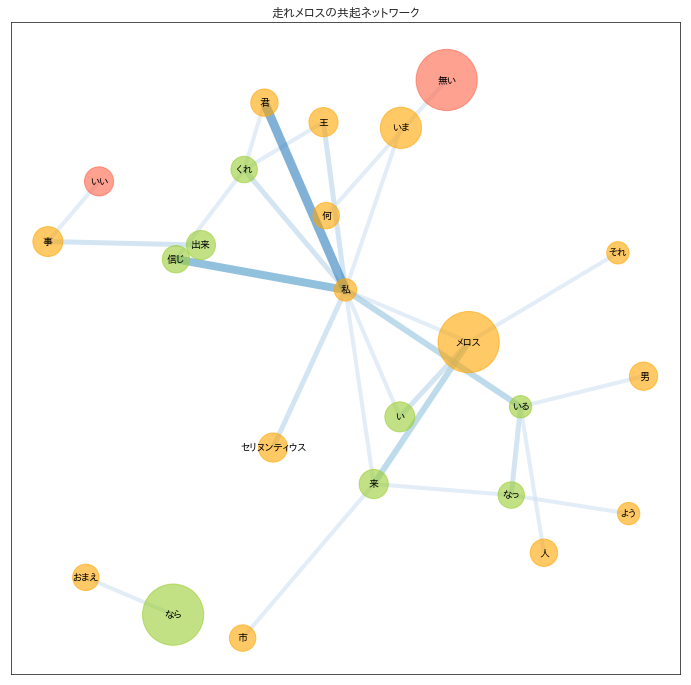

In [234]:
fig, ax = plt.subplots(figsize=(12,12))
nx.draw_networkx_nodes(G_result, pos, 
                       nodelist=[n for n in G_result.nodes() if n in node_type["名詞"]],  
                       node_size=node_size, node_color="orange", alpha=0.6, ax=ax)
nx.draw_networkx_nodes(G_result, pos, 
                       nodelist=[n for n in G_result.nodes() if n in node_type["動詞"]], 
                       node_size=node_size, node_color="yellowgreen", alpha=0.6, ax=ax)
nx.draw_networkx_nodes(G_result, pos, 
                       nodelist=[n for n in G_result.nodes() if n in node_type["形容詞"]], 
                       node_size=node_size, node_color="tomato", alpha=0.6, ax=ax)
nx.draw_networkx_edges(G_result, pos, alpha=0.6,
                       width=edge_width, edge_color=edge_colors, 
                       edge_vmin=0, edge_vmax=10,
                       edge_cmap=plt.cm.Blues,ax=ax)
nx .draw_networkx_labels(G_result, pos, labels, font_size=10, font_family="IPAPGothic", ax=ax)
ax.set_title("走れメロスの共起ネットワーク")

plt.show()

In [197]:
node_count[node_idx["何"]]

10

妹-さま: 国王の妹  
妹-羊: メロスの妹  
私-君: メロス→セリヌンティウスの会話文、「君は私を信じた~」など  
私-信じ: 「私を信じてくれ~」など